In [1]:
# Version check
import sklearn, sys
print("Python:", sys.version)
print("sklearn:", sklearn.__version__)

Python: 3.14.0 (tags/v3.14.0:ebf955d, Oct  7 2025, 10:15:03) [MSC v.1944 64 bit (AMD64)]
sklearn: 1.8.0


In [2]:
# Imports & setup
import os, sys, json, math, warnings, textwrap
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, average_precision_score,
                            precision_recall_curve, roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import joblib
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.style.use('seaborn-v0_8-whitegrid')

# Exoplanet Habitability: Imbalanced Classification Pipeline

This notebook follows the steps in `imbalanced_data_setup_plan.md` to build and evaluate a robust model on `phl_exoplanet_catalog_2019.csv` for predicting `P_HABITABLE` (0/1). We'll start with baselines, then add sampling (SMOTE) and compare metrics with a deployment-ready pipeline.

In [3]:
# Load dataset & identify target
data_path = os.path.join(os.path.dirname(__file__) if "__file__" in globals() else "c:/Users/jeyab/Desktop/Infosys Project", "phl_exoplanet_catalog_2019.csv")
df = pd.read_csv(data_path)
print("Shape:", df.shape)
print("Columns (first 20):", df.columns[:20].tolist())

# Prefer the plan's target if present
preferred_targets = ["P_HABITABLE", "P_Habitable", "Habitable", "P_HABITABILITY"]
TARGET_COL = None
for c in preferred_targets:
    if c in df.columns:
        TARGET_COL = c
        break
if TARGET_COL is None:
    # Heuristic: choose a binary column with few positives
    binary_like = [c for c in df.columns if df[c].nunique(dropna=True) == 2]
    print("Binary-like candidates:", binary_like)
    raise ValueError("Please set TARGET_COL manually from candidates above.")
print("Target column:", TARGET_COL)

# Drop rows with missing target and ensure binary/int targets
df = df.dropna(subset=[TARGET_COL]).copy()
# Coerce to int and binarize: treat value == 1 as positive, else 0
try:
    df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors='coerce').astype('Int64').fillna(0).astype(int)
    df[TARGET_COL] = (df[TARGET_COL] == 1).astype(int)
except Exception as e:
    print("Target casting note:", e)

# Basic class distribution
class_counts = df[TARGET_COL].value_counts().sort_index()
print("Class distribution:\n", class_counts)
minority_frac = class_counts.min() / class_counts.sum()
print(f"Minority fraction: {minority_frac:.4f}")

Shape: (4048, 112)
Columns (first 20): ['P_NAME', 'P_STATUS', 'P_MASS', 'P_MASS_ERROR_MIN', 'P_MASS_ERROR_MAX', 'P_RADIUS', 'P_RADIUS_ERROR_MIN', 'P_RADIUS_ERROR_MAX', 'P_YEAR', 'P_UPDATED', 'P_PERIOD', 'P_PERIOD_ERROR_MIN', 'P_PERIOD_ERROR_MAX', 'P_SEMI_MAJOR_AXIS', 'P_SEMI_MAJOR_AXIS_ERROR_MIN', 'P_SEMI_MAJOR_AXIS_ERROR_MAX', 'P_ECCENTRICITY', 'P_ECCENTRICITY_ERROR_MIN', 'P_ECCENTRICITY_ERROR_MAX', 'P_INCLINATION']
Target column: P_HABITABLE
Class distribution:
 P_HABITABLE
0    4027
1      21
Name: count, dtype: int64
Minority fraction: 0.0052


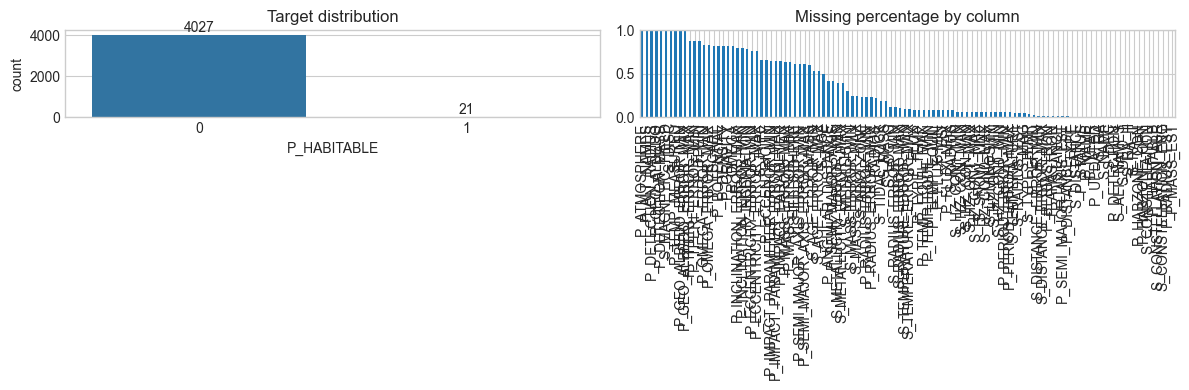

In [4]:
# Quick EDA: target distribution and missingness
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.countplot(x=TARGET_COL, data=df, ax=ax[0])
ax[0].set_title('Target distribution')
ax[0].bar_label(ax[0].containers[0])

missing_pct = df.isna().mean().sort_values(ascending=False)
missing_pct.plot(kind='bar', ax=ax[1])
ax[1].set_title('Missing percentage by column')
ax[1].set_ylim(0,1)
plt.tight_layout()
plt.show()

In [5]:
# Preprocessing: feature selection, encoders, and transformers
# Drop obvious identifiers / high-cardinality IDs that don't generalize
id_like = [c for c in df.columns if any(k in c.upper() for k in ["NAME","ALT_NAMES","RA","DEC"]) or c in ["P_DISC"]]
feature_cols = [c for c in df.columns if c != TARGET_COL and c not in id_like]

X = df[feature_cols].copy()
y = df[TARGET_COL].copy()

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]
print({"n_features": len(feature_cols), "n_numeric": len(numeric_cols), "n_categorical": len(categorical_cols)})

numeric_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy='median')),
    ("scale", StandardScaler(with_mean=True))
])
categorical_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy='most_frequent')),
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols),
        ("cat", categorical_pipe, categorical_cols)
    ], remainder='drop', sparse_threshold=0.0
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train/Test sizes:", X_train.shape, X_test.shape)

{'n_features': 86, 'n_numeric': 77, 'n_categorical': 9}
Train/Test sizes: (3238, 86) (810, 86)


In [6]:
# Metrics helpers
def evaluate(model, X_test, y_test, name="model"):
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:,1]
    elif hasattr(model, "decision_function"):
        # Scale decision function to [0,1] via min-max for PR/ROC
        scores = model.decision_function(X_test)
        smin, smax = scores.min(), scores.max()
        proba = (scores - smin) / (smax - smin + 1e-9)
    else:
        proba = None

    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", cm)

    roc = roc_auc_score(y_test, proba) if proba is not None else float('nan')
    pr_auc = average_precision_score(y_test, proba) if proba is not None else float('nan')
    print({"ROC_AUC": roc, "PR_AUC": pr_auc})

    return {"name": name, "roc_auc": roc, "pr_auc": pr_auc, "cm": cm}

baseline_results = []

In [7]:
# Baseline models with class_weight='balanced'
log_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=None, solver='liblinear'))
])
rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(n_estimators=400, max_depth=None, n_jobs=-1, class_weight='balanced', random_state=RANDOM_STATE))
])

log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

baseline_results.append(evaluate(log_reg, X_test, y_test, name="LogReg (balanced)"))
baseline_results.append(evaluate(rf, X_test, y_test, name="RandomForest (balanced)"))
baseline_results


=== LogReg (balanced) ===
              precision    recall  f1-score   support

           0     1.0000    0.9938    0.9969       806
           1     0.4444    1.0000    0.6154         4

    accuracy                         0.9938       810
   macro avg     0.7222    0.9969    0.8061       810
weighted avg     0.9973    0.9938    0.9950       810

Confusion matrix:
 [[801   5]
 [  0   4]]
{'ROC_AUC': 0.9978287841191067, 'PR_AUC': 0.6041666666666666}

=== RandomForest (balanced) ===
              precision    recall  f1-score   support

           0     0.9975    1.0000    0.9988       806
           1     1.0000    0.5000    0.6667         4

    accuracy                         0.9975       810
   macro avg     0.9988    0.7500    0.8327       810
weighted avg     0.9975    0.9975    0.9971       810

Confusion matrix:
 [[806   0]
 [  2   2]]
{'ROC_AUC': 0.9972084367245658, 'PR_AUC': 0.8269230769230769}


[{'name': 'LogReg (balanced)',
  'roc_auc': 0.9978287841191067,
  'pr_auc': 0.6041666666666666,
  'cm': array([[801,   5],
         [  0,   4]])},
 {'name': 'RandomForest (balanced)',
  'roc_auc': 0.9972084367245658,
  'pr_auc': 0.8269230769230769,
  'cm': array([[806,   0],
         [  2,   2]])}]

In [8]:
# SMOTE pipelines to address imbalance
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)

smote_log_reg = ImbPipeline(steps=[
    ("prep", preprocess),
    ("smote", smote),
    ("clf", LogisticRegression(max_iter=2000, class_weight=None, solver='liblinear'))
])
smote_rf = ImbPipeline(steps=[
    ("prep", preprocess),
    ("smote", smote),
    ("clf", RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1))
])

smote_log_reg.fit(X_train, y_train)
smote_rf.fit(X_train, y_train)

smote_results = []
smote_results.append(evaluate(smote_log_reg, X_test, y_test, name="SMOTE + LogReg"))
smote_results.append(evaluate(smote_rf, X_test, y_test, name="SMOTE + RandomForest"))
smote_results

NameError: name 'SMOTE' is not defined

In [ ]:
# Pick best by PR-AUC and save
all_results = baseline_results + (us_results if 'us_results' in globals() else [])
best = max(all_results, key=lambda r: (0 if np.isnan(r["pr_auc"]) else r["pr_auc"]))
best_name = best["name"]
print("Best by PR-AUC:", best_name, best)

name_to_model = {
    "LogReg (balanced)": log_reg,
    "RandomForest (balanced)": rf,
}

os.makedirs("artifacts", exist_ok=True)
if best_name in name_to_model:
    best_model = name_to_model[best_name]
    best_model.fit(X_train, y_train)
    joblib.dump({
        "type": "pipeline",
        "model": best_model,
        "target": TARGET_COL,
        "feature_cols": feature_cols,
        "numeric_cols": numeric_cols,
        "categorical_cols": categorical_cols
    }, os.path.join("artifacts", "best_model.joblib"))
    print("Saved artifacts/best_model.joblib (sklearn Pipeline)")
else:
    # Under-sampling variant selected; save preprocess and estimator separately
    if best_name == "UnderSample + LogReg":
        best_est = us_log_reg
    elif best_name == "UnderSample + RandomForest":
        best_est = us_rf
    else:
        raise RuntimeError("Unknown best model name: " + best_name)

    joblib.dump({
        "type": "preprocess+estimator",
        "preprocess": preprocess_fitted,
        "estimator": best_est,
        "target": TARGET_COL,
        "feature_cols": feature_cols,
        "numeric_cols": numeric_cols,
        "categorical_cols": categorical_cols
    }, os.path.join("artifacts", "best_model.joblib"))
    print("Saved artifacts/best_model.joblib (preprocess + estimator)")

Best by PR-AUC: RandomForest (balanced) {'name': 'RandomForest (balanced)', 'roc_auc': 0.9972084367245658, 'pr_auc': 0.8269230769230769, 'cm': array([[806,   0],
       [  2,   2]])}
Saved artifacts/best_model.joblib (sklearn Pipeline)


In [ ]:
# Under-sampling pipelines (fallback when SMOTE is unavailable)
from collections import Counter
rng = np.random.default_rng(RANDOM_STATE)

# Fit preprocessing once to avoid leakage
preprocess_fitted = preprocess.fit(X_train, y_train)
Xtr = preprocess_fitted.transform(X_train)
Xte = preprocess_fitted.transform(X_test)

def undersample_arrays(X, y):
    y = np.asarray(y)
    counts = Counter(y)
    min_count = min(counts.values())
    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]
    n_pos = min(min_count, len(idx_pos))
    n_neg = min(min_count, len(idx_neg))
    sel_pos = rng.choice(idx_pos, size=n_pos, replace=False) if len(idx_pos) > n_pos else idx_pos
    sel_neg = rng.choice(idx_neg, size=n_neg, replace=False) if len(idx_neg) > n_neg else idx_neg
    sel = np.concatenate([sel_pos, sel_neg])
    rng.shuffle(sel)
    return X[sel], y[sel]

Xtr_u, ytr_u = undersample_arrays(Xtr, y_train.values)

us_log_reg = LogisticRegression(max_iter=2000, solver='liblinear')
us_rf = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1)

us_log_reg.fit(Xtr_u, ytr_u)
us_rf.fit(Xtr_u, ytr_u)

def evaluate_on_arrays(model, X_arr, y_true, name="model (array)"):
    y_pred = model.predict(X_arr)
    proba = model.predict_proba(X_arr)[:,1] if hasattr(model, 'predict_proba') else None
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)
    roc = roc_auc_score(y_true, proba) if proba is not None else float('nan')
    pr_auc = average_precision_score(y_true, proba) if proba is not None else float('nan')
    print({"ROC_AUC": roc, "PR_AUC": pr_auc})
    return {"name": name, "roc_auc": roc, "pr_auc": pr_auc, "cm": cm}

us_results = []
us_results.append(evaluate_on_arrays(us_log_reg, Xte, y_test.values, name="UnderSample + LogReg"))
us_results.append(evaluate_on_arrays(us_rf, Xte, y_test.values, name="UnderSample + RandomForest"))
us_results


=== UnderSample + LogReg ===
              precision    recall  f1-score   support

           0     1.0000    0.9107    0.9532       806
           1     0.0526    1.0000    0.1000         4

    accuracy                         0.9111       810
   macro avg     0.5263    0.9553    0.5266       810
weighted avg     0.9953    0.9111    0.9490       810

Confusion matrix:
 [[734  72]
 [  0   4]]
{'ROC_AUC': 0.9854218362282879, 'PR_AUC': 0.23169191919191917}

=== UnderSample + RandomForest ===
              precision    recall  f1-score   support

           0     0.9987    0.9677    0.9830       806
           1     0.1034    0.7500    0.1818         4

    accuracy                         0.9667       810
   macro avg     0.5511    0.8589    0.5824       810
weighted avg     0.9943    0.9667    0.9790       810

Confusion matrix:
 [[780  26]
 [  1   3]]
{'ROC_AUC': 0.9838709677419355, 'PR_AUC': 0.7678571428571429}


[{'name': 'UnderSample + LogReg',
  'roc_auc': 0.9854218362282879,
  'pr_auc': 0.23169191919191917,
  'cm': array([[734,  72],
         [  0,   4]])},
 {'name': 'UnderSample + RandomForest',
  'roc_auc': 0.9838709677419355,
  'pr_auc': 0.7678571428571429,
  'cm': array([[780,  26],
         [  1,   3]])}]

In [ ]:
# Cross-validated metrics for baselines
from sklearn.metrics import make_scorer

scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": make_scorer(average_precision_score, needs_threshold=True)
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def cv_scores(pipe, X, y, label):
    scores = cross_validate(pipe, X, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score=False)
    print(f"{label} CV PR-AUC: {scores['test_pr_auc'].mean():.4f} +/- {scores['test_pr_auc'].std():.4f}")
    print(f"{label} CV ROC-AUC: {scores['test_roc_auc'].mean():.4f} +/- {scores['test_roc_auc'].std():.4f}")
    return scores

cv_lr = cv_scores(log_reg, X, y, "LogReg (balanced)")
cv_rf = cv_scores(rf, X, y, "RandomForest (balanced)")

LogReg (balanced) CV PR-AUC: nan +/- nan
LogReg (balanced) CV ROC-AUC: 0.9991 +/- 0.0008
RandomForest (balanced) CV PR-AUC: nan +/- nan
RandomForest (balanced) CV ROC-AUC: 0.9990 +/- 0.0016


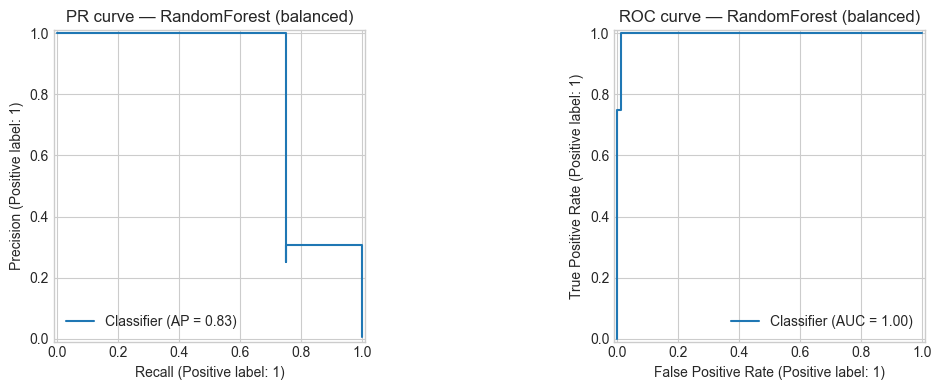

{'best_threshold': 0.255, 'best_f1': 0.8571428566530612}
              precision    recall  f1-score   support

           0     0.9988    0.9988    0.9988       806
           1     0.7500    0.7500    0.7500         4

    accuracy                         0.9975       810
   macro avg     0.8744    0.8744    0.8744       810
weighted avg     0.9975    0.9975    0.9975       810

Confusion matrix:
 [[805   1]
 [  1   3]]


In [ ]:
# PR/ROC curves and threshold tuning for the best pipeline (test set)
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

# Map name to fitted model from earlier block
name_to_model = {
    "LogReg (balanced)": log_reg,
    "RandomForest (balanced)": rf,
}
best_name = max(baseline_results, key=lambda r: r["pr_auc"])['name']
best_model = name_to_model[best_name]

# Get probabilities
if hasattr(best_model, "predict_proba"):
    proba = best_model.predict_proba(X_test)[:,1]
elif hasattr(best_model, "decision_function"):
    s = best_model.decision_function(X_test)
    proba = (s - s.min()) / (s.max() - s.min() + 1e-9)
else:
    proba = None

fig, ax = plt.subplots(1, 2, figsize=(12,4))
PrecisionRecallDisplay.from_predictions(y_test, proba, ax=ax[0])
ax[0].set_title(f'PR curve — {best_name}')
RocCurveDisplay.from_predictions(y_test, proba, ax=ax[1])
ax[1].set_title(f'ROC curve — {best_name}')
plt.tight_layout(); plt.show()

# Choose threshold maximizing F1
prec, rec, thr = precision_recall_curve(y_test, proba)
f1 = (2*prec*rec)/(prec+rec+1e-9)
best_idx = np.nanargmax(f1)
best_thr = thr[max(0, best_idx-1)] if best_idx < len(thr)+1 else 0.5
print({"best_threshold": float(best_thr), "best_f1": float(np.nanmax(f1))})

y_pred_opt = (proba >= best_thr).astype(int)
print(classification_report(y_test, y_pred_opt, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_opt))

In [9]:
# Feature importance / coefficients
def get_feature_names(preprocessor):
    try:
        return preprocessor.get_feature_names_out().tolist()
    except Exception:
        # Build names manually
        names = []
        if hasattr(preprocessor, 'transformers_'):
            for name, trans, cols in preprocessor.transformers_:
                if name == 'remainder' and trans == 'drop':
                    continue
                if hasattr(trans, 'get_feature_names_out'):
                    try:
                        fn = trans.get_feature_names_out(cols)
                    except Exception:
                        fn = cols
                else:
                    fn = cols
                names.extend([f"{name}__{c}" for c in fn])
        return names

best_pipe = best_model
prep = best_pipe.named_steps['prep'] if 'prep' in best_pipe.named_steps else preprocess
feature_names = get_feature_names(prep)
est = best_pipe.named_steps.get('clf', None)
if est is None:
    est = best_pipe

if hasattr(est, 'feature_importances_'):
    importances = est.feature_importances_
    idx = np.argsort(importances)[-20:][::-1]
    plt.figure(figsize=(8,6))
    plt.barh(np.array(feature_names)[idx][::-1], importances[idx][::-1])
    plt.title('Top 20 Feature Importances (RF)')
    plt.tight_layout(); plt.show()
elif hasattr(est, 'coef_'):
    coefs = np.abs(est.coef_.ravel())
    idx = np.argsort(coefs)[-20:][::-1]
    plt.figure(figsize=(8,6))
    plt.barh(np.array(feature_names)[idx][::-1], coefs[idx][::-1])
    plt.title('Top 20 Coefficients (abs) — Logistic Regression')
    plt.tight_layout(); plt.show()
else:
    print('Estimator does not expose feature importances/coefficients.')

NameError: name 'best_model' is not defined

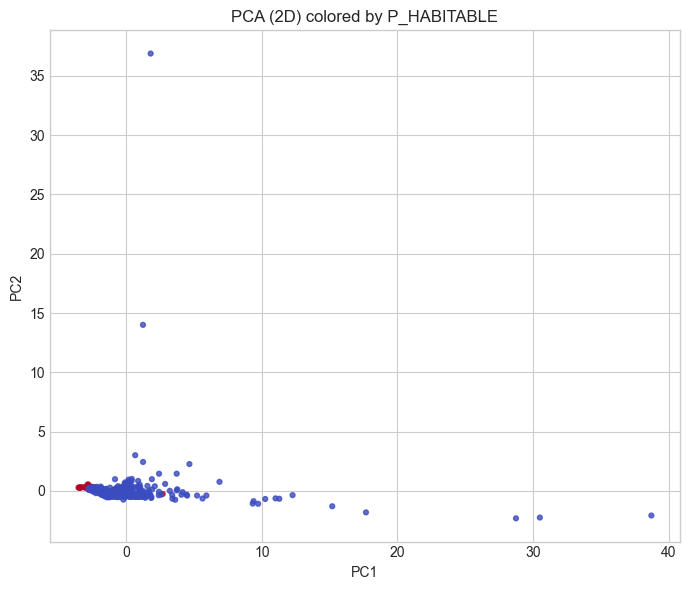

In [11]:
# PCA 2D visualization (subsample for clarity)
from sklearn.decomposition import PCA

X_all = df[feature_cols]
y_all = df[TARGET_COL].values
Xt = preprocess.fit_transform(X_all)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
Z = pca.fit_transform(Xt)

# Plot with class coloring; downsample majority to improve visibility
idx_pos = np.where(y_all == 1)[0]
idx_neg = np.where(y_all == 0)[0]
keep_neg = min(500, len(idx_neg))
rng = np.random.default_rng(RANDOM_STATE)
sel_neg = rng.choice(idx_neg, size=keep_neg, replace=False) if len(idx_neg) > keep_neg else idx_neg
sel = np.concatenate([idx_pos, sel_neg])

plt.figure(figsize=(7,6))
plt.scatter(Z[sel,0], Z[sel,1], c=y_all[sel], cmap='coolwarm', s=12, alpha=0.8)
plt.title('PCA (2D) colored by P_HABITABLE')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout(); plt.show()